In [1]:
from imblearn.under_sampling import(
    RandomUnderSampler as RUS,
    CondensedNearestNeighbour as CNN,
    TomekLinks as TL,
    OneSidedSelection as OSS,
    EditedNearestNeighbours as ENN,
    RepeatedEditedNearestNeighbours as RENN,
    AllKNN,
    NeighbourhoodCleaningRule as NCR,
    NearMiss as NM,
    InstanceHardnessThreshold as IHT
)
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC

In [2]:
sampling_dict={
    'random sampling':RUS(
        sampling_strategy='auto',
        random_state=0,
        replacement=False
    ),
    'condensed NN':CNN(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=-1
    ),
    'tomek links':TL(
        sampling_strategy='auto',
        n_jobs=-1
    ),
    'one Side Selection':OSS(
        sampling_strategy='auto',
        random_state=0,
        n_neighbors=1,
        n_jobs=-1
    ),
    'edited NN':ENN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1
    ),
    'repeated ENN':RENN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1
    ),
    'all KNN':AllKNN(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1
    ),
    'neighbouehood cleaning':NCR(
        sampling_strategy='auto',
        n_neighbors=3,
        kind_sel='all',
        n_jobs=-1,
        threshold_cleaning=0.5
    ),
    'near miss v1':NM(
        sampling_strategy='auto',
        version=1,
        n_neighbors=3,
        n_jobs=-1
    ),
    'near miss v2':NM(
        sampling_strategy='auto',
        version=2,
        n_neighbors=3,
        n_jobs=-1
    ),
    'instance hardness threshold logistic regression':IHT(
        estimator=LR(
            max_iter=1000,
            random_state=0
        ),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=-1,
        cv=4
    ),
    'instance hardness threshold random forrest':IHT(
        estimator=RFC(
            n_estimators=100,
            max_depth=4,
            n_jobs=-1,
            random_state=0
        ),
        sampling_strategy='auto',
        random_state=0,
        n_jobs=-1,
        cv=4
    )
}

In [3]:
from imblearn.datasets import fetch_datasets as FD
import pandas as pd

In [4]:
data=pd.DataFrame(
    pd.concat([pd.DataFrame(
                    FD()['ecoli']['data'],
                    columns=['var_0','var_1','var_2','var_3','var_4','var_5','var_6']
                            ),
                pd.Series(
                    FD()['ecoli']['target'],
                    name='target' 
                        )],
                axis=1
            ),
)

In [5]:
data['target']=data['target'].map({-1:0,1:1})

In [6]:
from sklearn.metrics import roc_auc_score as RAS

In [7]:
def run_RandomForest(x_train,x_test,y_train,y_test):
    rf=RFC(
        n_estimators=100,
        max_depth=4,
        n_jobs=-1,
        random_state=0
    )
    rf.fit(x_train,y_train)
    pred=rf.predict_proba(x_train)
    print('Training set: ')
    print('ROC AUC score: {}'.format(RAS(y_train,pred[:,1])))
    pred=rf.predict_proba(x_test)
    print('Test set: ')
    print('ROC AUC score: {}'.format(RAS(y_test,pred[:,1])))
    return RAS(y_test,pred[:,1])

In [8]:
def run_LogisticRegression(x_train,x_test,y_train,y_test):
    lr=LR(
        max_iter=1000,
        n_jobs=-1,
        random_state=0
    )
    lr.fit(x_train,y_train)
    pred=lr.predict_proba(x_train)
    print('Training set: ')
    print('ROC AUC score: {}'.format(RAS(y_train,pred[:,1])))
    pred=lr.predict_proba(x_test)
    print('Test set: ')
    print('ROC AUC score: {}'.format(RAS(y_test,pred[:,1])))
    return RAS(y_test,pred[:,1])

In [15]:
estimators={
    'random forest':run_RandomForest,
    'logistic regression':run_LogisticRegression
}

In [10]:
from sklearn.model_selection import train_test_split as TTS
from sklearn.preprocessing import MinMaxScaler as MMS

In [11]:
def run_sampler(data):
    roc_score={}
    x_train,x_test,y_train,y_test=TTS(
        data.drop(labels='target',axis=1),
        data['target'],
        test_size=0.3,
        random_state=0
    )
    
    scale=MMS()
    x_train=scale.fit_transform(x_train)
    x_test=scale.transform(x_test)
    
    for estimator in estimators.keys():
        roc_score[estimator]={}
        print(estimator)
        print('-'*20)
        print('full data')
        roc=estimators[estimator](x_train,x_test,y_train,y_test)
        roc_score[estimator]['full data']=roc
        print()
        for sampler in sampling_dict.keys():
            print(sampler)
            x_sample,y_sample=sampling_dict[sampler].fit_resample(x_train,y_train)
            roc=estimators[estimator](x_sample,x_test,y_sample,y_test)
            roc_score[estimator][sampler]=roc
            print()
    return roc_score

In [12]:
roc=run_sampler(data)

random forrest
--------------------
full data
Training set: 
ROC AUC score: 0.9948472580051528
Test set: 
ROC AUC score: 0.9601449275362318

random sampling
Training set: 
ROC AUC score: 1.0
Test set: 
ROC AUC score: 0.9480676328502415

condensed NN
Training set: 
ROC AUC score: 0.9957264957264957
Test set: 
ROC AUC score: 0.9649758454106281

tomek links
Training set: 
ROC AUC score: 0.9981053429329291
Test set: 
ROC AUC score: 0.9601449275362318

one Side Selection
Training set: 
ROC AUC score: 0.9971509971509972
Test set: 
ROC AUC score: 0.8864734299516909

edited NN
Training set: 
ROC AUC score: 1.0
Test set: 
ROC AUC score: 0.961352657004831

repeated ENN
Training set: 
ROC AUC score: 1.0
Test set: 
ROC AUC score: 0.9601449275362319

all KNN
Training set: 
ROC AUC score: 1.0
Test set: 
ROC AUC score: 0.963768115942029

neighbouehood cleaning
Training set: 
ROC AUC score: 1.0
Test set: 
ROC AUC score: 0.9565217391304348

near miss v1
Training set: 
ROC AUC score: 1.0
Test set: 
ROC 

In [17]:
import matplotlib.pyplot as plt

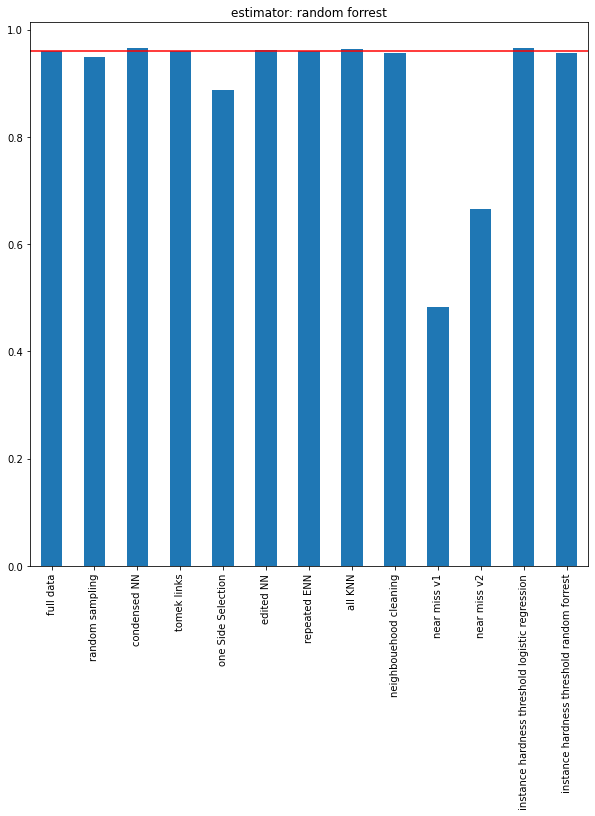

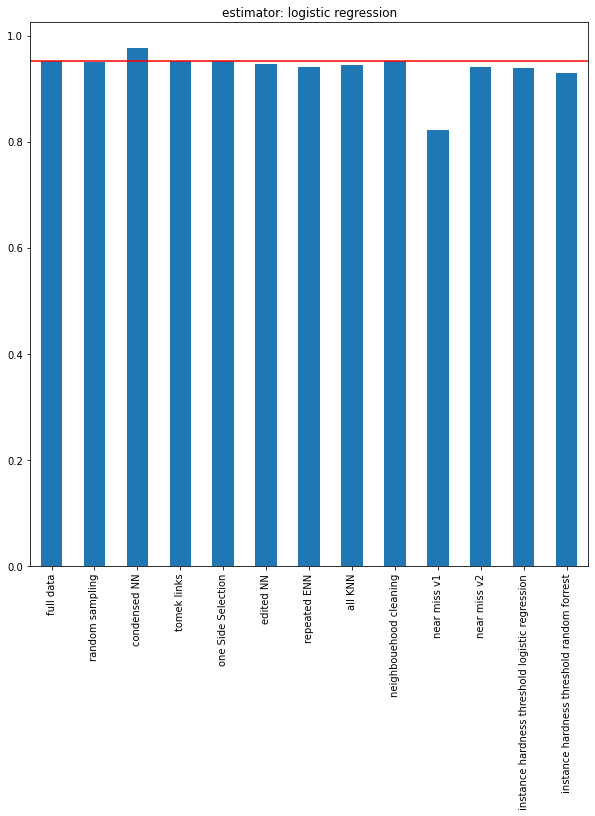

In [22]:
for i in roc.keys():
    pd.Series(roc[i]).plot.bar(figsize=(10,10))
    plt.axhline(y=roc[i]['full data'],c='red')
    plt.title('estimator: {}'.format(i))
    plt.show()